<a href="https://colab.research.google.com/github/ericburdett/cs601r-dl/blob/master/DL_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS601R - Advanced Deep Learning

## Lab 1 - Basic Classifier

### Objective

* Code a basic classifier in pytorch. Prepare a scaffold that will be used for experimentation in future labs.


### Deliverable

* For this lab, you will submit an ipython notebook via learningsuite. Your notebook must contain your classifier code, and should show various final statistics about it and its performance. You should plot your loss curve, a final confusion matrix, and you must clearly display the total parameter count of your network.

### Grading Standards

Your notebook will be graded on the following:

* 45% Successfully created resnet
* 5% Clearly display the total parameter count of your network
* 20% Plotted loss curve
* 20% Showed final confusion matrix
* 10% Tidy and legible figures, including labeled axes where appropriate

### Description

For this lab, you will implement a basic pytorch image classifier on a reasonably large dataset.

Details:

Your classifier must be a 20 layer Resnet.

The dataset is the Tiny Imagenet dataset. It has 200 classes, and 500 training images per class (for a total of 100k training images), and 10,000 testing images. (The dataset provides both labels and bounding boxes; you can ignore the boxes)

You will probably want to use Google colab to host your notebook.

For your loss curve, any reasonable visualization is acceptable.

For your confusion matrix, you should display a 200×200 image, where each pixel i,j represents the number of times an image of class i was classified as class j.

You will not be graded on any final accuracies. I think this is a pretty hard dataset, so I would not expect much better performance than 40% accuracy.

You may use any code on the internet to help you, but all submitted code must be your own work.

MAJOR HINT: we will be working with this classifier in future labs by adjusting its hyper parameters. In particular, you should make it easy to:

* Change the activation function
* Change whether or not you use BatchNorm
* Change the learning rate schedule
* Change the weight regularization
* Change the weight initialization

## Import & Create the Tiny-Imagenet Dataset

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
from PIL import Image, ImageOps
import gc
import pdb
from google.colab import drive
drive.mount('/content/drive')
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "Request a GPU from Runtime > Change Runtime"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "drive/My Drive/datasets/tiny-imagenet-200.zip" "/content"

In [0]:
!unzip tiny-imagenet-200.zip

In [0]:
class TinyImagenetDataset(Dataset):
  def __init__(self, dataset_type='train'):
    if not os.path.exists('/content/tiny-imagenet-200'):
      raise Exception('Tiny-Imagenet dataset does not exist!')

    if dataset_type == 'train':
      self.dataset_folder = torchvision.datasets.ImageFolder('/content/tiny-imagenet-200/train',
                                                             transform=transforms.Compose([transforms.ToTensor()]))
    elif dataset_type == 'val':
      self.dataset_folder = torchvision.datasets.ImageFolder('/content/tiny-imagenet-200/val',
                                                             transform=transforms.Compose([transforms.ToTensor()]))
    else:
      self.dataset_folder = torchvision.datasets.ImageFolder('/content/tiny-imagenet-200/test',
                                                             transform=transforms.Compose([transforms.ToTensor()]))
    
  def num_classes(self):
    return len(self.dataset_folder.class_to_idx)

  def __getitem__(self, index):
    return self.dataset_folder[index]

  def __len__(self):
    return len(self.dataset_folder)

## Model Implementation - 20 Layer Resnet

In [0]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, batch_norm=True, activation=nn.ReLU):
    super(ResidualBlock, self).__init__()

    self.activation = activation

    if batch_norm:
      self.net = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        self.activation(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels)
      )
    else:
      self.net = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        self.activation(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1)
      )

    if in_channels != out_channels:
      self.needs_shortcut = True
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 1, bias=False),
        nn.BatchNorm2d(out_channels)
      )
    else:
      self.needs_shortcut = False

  def forward(self, x):
    identity = x if not self.needs_shortcut else self.shortcut(x)
    out = self.net(x)
    out += identity
    final_activation = self.activation()

    return final_activation(out)


In [0]:
class Resnet(nn.Module):
  def __init__(self, dataset, num_classes):
    super(Resnet, self).__init__()

    x, y = dataset[0]
    in_channels, height, width = x.size()
    cstart = 64

    layers = []
    layers.append(ResidualBlock(in_channels, cstart))
    for i in range(19):
      layers.append(ResidualBlock(cstart, cstart))
  
    self.net = nn.Sequential(*layers)
    self.fc1 = nn.Linear(cstart * height * width, num_classes)

  def forward(self, x):
    # Residual Blocks
    out = self.net(x)

    # Flatten and narrow down to the number of classes
    out = torch.flatten(out, 1)
    out = self.fc1(out)

    return out

In [0]:
class PytorchResnet(nn.Module):
  def __init__(self, num_classes):
    super(PytorchResnet, self).__init__()

    self.model = torchvision.models.resnet152(pretrained=True)

    fc = nn.Linear(in_features=2048, out_features=num_classes)
    fc.requires_grad=True
    self.model.fc = fc

  def forward(self, x):
    return self.model(x)

In [199]:
def train():
  NUM_EPOCHS = 10
  BATCH_SIZE = 100

  train_dataset = torchvision.datasets.CIFAR10('/content/cifar-train', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
  val_dataset = torchvision.datasets.CIFAR10('/content/cifar-val', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

  model = Resnet(train_dataset, 10) #PytorchResnet(dataset.num_classes())
  model = model.cuda()

  objective = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-4)

  train_loader = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                            num_workers=4,
                            shuffle=True)
  val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)
  
  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []
  
  predictions = np.array([])
  actual = np.array([])

  for epoch in range(NUM_EPOCHS):
    loop = tqdm(total=len(train_loader), position=0, leave=True)

    for batch, (x, y_truth) in enumerate(train_loader):
      gc.collect()
      x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)

      optimizer.zero_grad()
      y_hat = model(x)

      acc = torch.eq(y_hat.argmax(1), y_truth.long()).float().mean()
      loss = objective(y_hat, y_truth.long())

      loss.backward()

      train_accs.append(acc.item())
      train_losses.append(loss.item())

      loop.set_description('Train - epoch:{}, loss:{:.4f}, acc:{:.4f}, avgloss:{:.4f}, avgacc:{:.4f}'.format(epoch, loss.item(), acc.item(), np.mean(train_losses), np.mean(train_accs)))
      loop.update(1)

      optimizer.step()

    with torch.no_grad():

      val_single_loss = []
      val_single_acc = []

      model.eval()

      for _, (val_x, val_y_truth) in enumerate(val_loader):
        gc.collect()
        val_x, val_y_truth = val_x.cuda(), val_y_truth.cuda()

        val_y_hat = model(val_x)

        if epoch == (NUM_EPOCHS - 1):
          predictions = np.append(predictions, val_y_hat.argmax(1).cpu().numpy())
          actual = np.append(actual, val_y_truth.cpu().numpy())

        val_acc = torch.eq(val_y_hat.argmax(1), val_y_truth.long()).float().mean()
        val_loss = objective(val_y_hat, val_y_truth.long())

        val_single_loss.append(val_loss.item())
        val_single_acc.append(val_acc.item())

      print('\nValidation - epoch:{}, loss:{:.4f}, acc:{:.4f}'.format(epoch, np.mean(val_single_loss), np.mean(val_single_acc)))

      val_accs.append(np.mean(val_single_acc))
      val_losses.append(np.mean(val_single_loss))

  loop.close()

  return model, train_losses, train_accs, val_losses, val_accs, predictions, actual

try:
  model, train_losses, train_accs, val_losses, val_accs, predictions, actual = train()
  gc.collect()
except:
  gc.collect()
  __ITB__()

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/500 [00:00<?, ?it/s]


Validation - epoch:0, loss:1.3367, acc:0.5372


  0%|          | 0/500 [00:00<?, ?it/s]


Validation - epoch:1, loss:1.0820, acc:0.6120


  0%|          | 0/500 [00:00<?, ?it/s]


Validation - epoch:2, loss:0.9527, acc:0.6610


  0%|          | 0/500 [00:00<?, ?it/s]


Validation - epoch:3, loss:0.9291, acc:0.6760


  0%|          | 0/500 [00:00<?, ?it/s]


Validation - epoch:4, loss:0.9427, acc:0.6753


  0%|          | 0/500 [00:00<?, ?it/s]


Validation - epoch:5, loss:1.0430, acc:0.6673


  0%|          | 0/500 [00:00<?, ?it/s]


Validation - epoch:6, loss:0.9785, acc:0.6934


  0%|          | 0/500 [00:00<?, ?it/s]


Validation - epoch:7, loss:1.2273, acc:0.6678


  0%|          | 0/500 [00:00<?, ?it/s]


Validation - epoch:8, loss:1.2806, acc:0.6719


Train - epoch:9, loss:0.2170, acc:0.9200, avgloss:0.7132, avgacc:0.7745: 100%|██████████| 500/500 [02:13<00:00,  3.85it/s]


Validation - epoch:9, loss:1.4586, acc:0.6690


## Parameter Count

In [206]:
print("Parameter Count: ", sum(param.numel() for param in model.parameters()))

Parameter Count:  2102794


## Plot the Loss/Accuracy Curves

In [220]:
[x for x in range(len(train_losses) // len(val_losses), len(train_losses) + 1, len(train_losses) // len(val_losses))]

[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

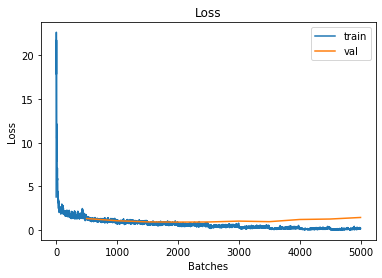

In [226]:
plt.title('Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
val_x, val_y = [x for x in range(len(train_losses) // len(val_losses), len(train_losses) + 1, len(train_losses) // len(val_losses))], val_losses
plt.plot(train_losses, label='train')
plt.plot(val_x, val_y, label='val')
plt.legend()
plt.show()

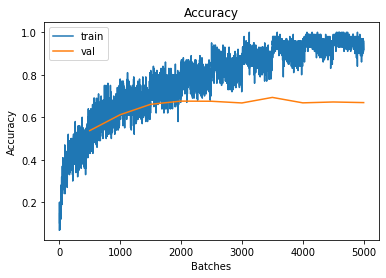

In [227]:
plt.title('Accuracy')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
val_x, val_y = [x for x in range(len(train_accs) // len(val_accs), len(train_accs) + 1, len(train_accs) // len(val_accs))], val_accs
plt.plot(train_accs, label='train')
plt.plot(val_x, val_y, label='val')
plt.legend()
plt.show()

## Plot the Confusion Matrix

In [228]:
from sklearn.metrics import confusion_matrix

confusion_matrix(actual, predictions)

array([[803,  13,   7,  14,  31,  10,  18,  14,  43,  47],
       [ 39, 782,   3,   9,   7,   5,   9,   9,  10, 127],
       [129,  10, 327,  58, 178, 134,  84,  56,  11,  13],
       [ 35,   8,  24, 399, 105, 282,  71,  39,  13,  24],
       [ 32,   3,  16,  45, 716,  53,  54,  70,   6,   5],
       [ 17,   3,  14, 136,  55, 678,  14,  58,   5,  20],
       [ 16,   2,  14,  53,  96,  48, 744,  14,   5,   8],
       [ 27,   1,  12,  17,  99,  85,   6, 724,   2,  27],
       [128,  41,   6,   9,  16,  12,   6,   8, 736,  38],
       [ 49,  95,   4,  13,   9,   7,   8,  20,  14, 781]])